In [1]:
from kernel import calc_kernel
import kernel
import numpy as np
import copy

In [2]:
calc_kernel.__doc__

"arr = calc_kernel(array,px,py,p,[nx,ny])\n\nWrapper for ``calc_kernel``.\n\nParameters\n----------\narray : input rank-2 array('d') with bounds (nx,ny)\npx : input int\npy : input int\np : input int\n\nOther Parameters\n----------------\nnx : input int, optional\n    Default: shape(array,0)\nny : input int, optional\n    Default: shape(array,1)\n\nReturns\n-------\narr : rank-2 array('d') with bounds (nx,ny)\n"

In [3]:
def psi(x, y, alpha=0.0):
    """
    Функция линии тока
    """
    alpha = np.deg2rad(alpha)
    return np.cos(alpha) * y - np.sin(alpha) * x


def calculate_init_cond(array, xx, yy, alpha):
    """
    Вычисляет первое приближение

    Принимает:
        - field:array - вычислительную область
        - psi:function - функция, описывающая начальные условия
        - x, y:array - векторы координат
    Возвращает:
        - :array - вычислительную область с граничными условиями
    """
    arr = copy.deepcopy(array)
    arr = psi(xx, yy, alpha)
    return arr


def calculate_psi(psi_prev, NX, NY, px, py, P, ITER=1000, eps=0.001):
    """
    Основной алгоритм для вычисления пси

    Параметры:
        psi_prev - массив начальных приближений размерности (NX,NY) 
        NX, NY - количество шагов разбиения по оси OX, OY
        px, py - координаты точек пластины
        P - количество точек
        ITER - количество итераций
        eps - погрешность
    """
    delta = []

    iter_now = 0
    
    for iter in range(1, ITER):
        psi_now = calc_kernel(psi_prev, px=px, py=py,p=P, nx=NX, ny=NY)
        delta_ = np.max(np.abs(psi_now - psi_prev))

        if iter % 150 == 0:
            print(f'iter {iter:5}\teps {delta_:.8f}')

        psi_prev = copy.deepcopy(psi_now)
        
        if iter % 50 == 0:
            delta.append(delta_)
        
        if delta_ < eps: 
            print(f"\nРасчет окончен на {iter} итерации")
            iter_now = iter
            break
            
    return psi_now, delta, iter_now

In [4]:
X, Y = 10.0, 10.0
NX, NY = 500, 500
px, py = NX // 2, NY // 3
P = NY - 2 * py

eps = 1e-3
ITER = 100000

x = np.linspace(0, X, NX)
y = np.linspace(0, Y, NY)

xx, yy = np.meshgrid(x,y)

hx = xx[0, 1] - xx[0, 0]
hy = yy[1,0] - yy[0,0]

alpha = 15
z = np.zeros(xx.shape, dtype='f8', order='F')
z = calculate_init_cond(z, xx, yy, alpha)

psi_prev = copy.deepcopy(z)

In [5]:
%%time 
psi_now, delta, iter_now = calculate_psi(psi_prev, NX, NY, px, py, P, ITER=ITER, eps=eps)

iter   150	eps 0.00215371

Расчет окончен на 293 итерации
CPU times: user 1.13 s, sys: 24.2 ms, total: 1.15 s
Wall time: 1.2 s


In [6]:
from pandas import read_csv
from pandas import DataFrame as DF
import matplotlib.pyplot as plt

In [6]:
CP_e3 = read_csv('cp.csv')
CP_teor = read_csv('cp_teor.csv')

In [66]:
Cp_e5_for500 = []
k = py+1
for i in range(P-1):
    k += 1
    vel = (psi_now[k, px-1] - psi_now[k, px+1]) / 2 / hx
    
    Cp_e5_for500.append(1.0 - vel*vel)

In [67]:
Cp_e5_for500df = DF(Cp_e5_for500)
Cp_e5_for500df.to_csv('CP_for500_e5.csv', index=False)

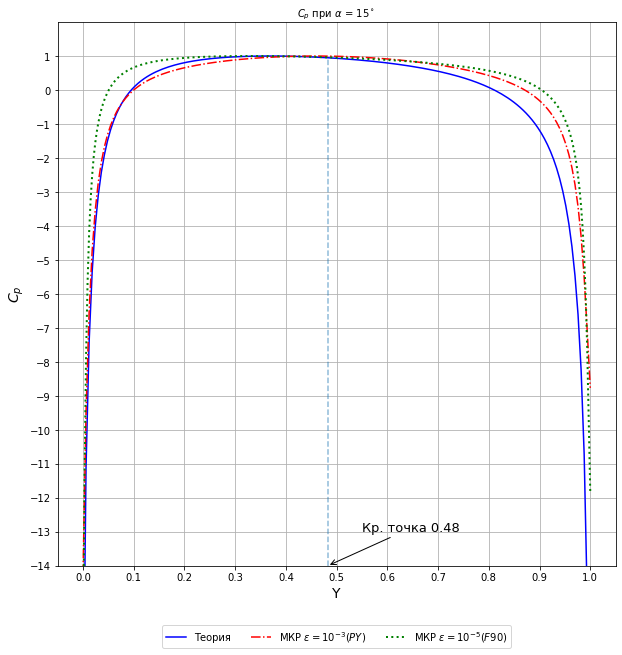

In [78]:
ymin = int(np.ceil(np.min(CP_teor)))
u = np.linspace(0, 1, 167)
u_new = np.linspace(0, 1, 333)
xt = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(10,10))
plt.plot(u, CP_teor[::-1], label='Теория', color='b')
plt.plot(u, CP_e3[::-1], label=r'МКР $\epsilon=10^{-3} (PY)$', color='r', ls='-.')
# plt.plot(u_new, Cp_e3_for[::-1], label=r'МКР $\epsilon=10^{-3} (F90)$', color='g', ls=':', lw=2)
plt.plot(u_new, Cp_e5_for[::-1], label=r'МКР $\epsilon=10^{-5} (F90)$', color='g', ls=':', lw=2)
# plt.plot(u, Cp_e5_for500[::-1], label=r'МКР $\epsilon=10^{-5} nx=500$', color='g', ls=':', lw=2)

plt.axvline(0.5 * np.cos(np.deg2rad(15)), ymax=0.935, ls='--', alpha=0.5)

plt.annotate("Кр. точка 0.48", xy=(0.5 * np.cos(np.deg2rad(15)), -14), xytext=(0.55, -13),
                arrowprops=dict(arrowstyle="->"), fontsize=13)

plt.yticks(np.arange(ymin, 2, 1))
plt.xticks(xt)

plt.ylim(-14, 2)
plt.title(r'$C_p$ при $\alpha$ = 15$^\circ$', fontsize=10)
plt.xlabel(r'Y', fontsize=14)
plt.ylabel(r'$C_p$', fontsize=14)
# plt.legend(loc='best', fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 0., 0., -0.1), ncol=3, fontsize=10)
plt.grid();
# plt.savefig('CP_with_fore5_py3.jpg', dpi=200, bbox_inches='tight')

Text(0.5, 1.0, 'Линии тока при $\\alpha$ = 15$^\\circ$')

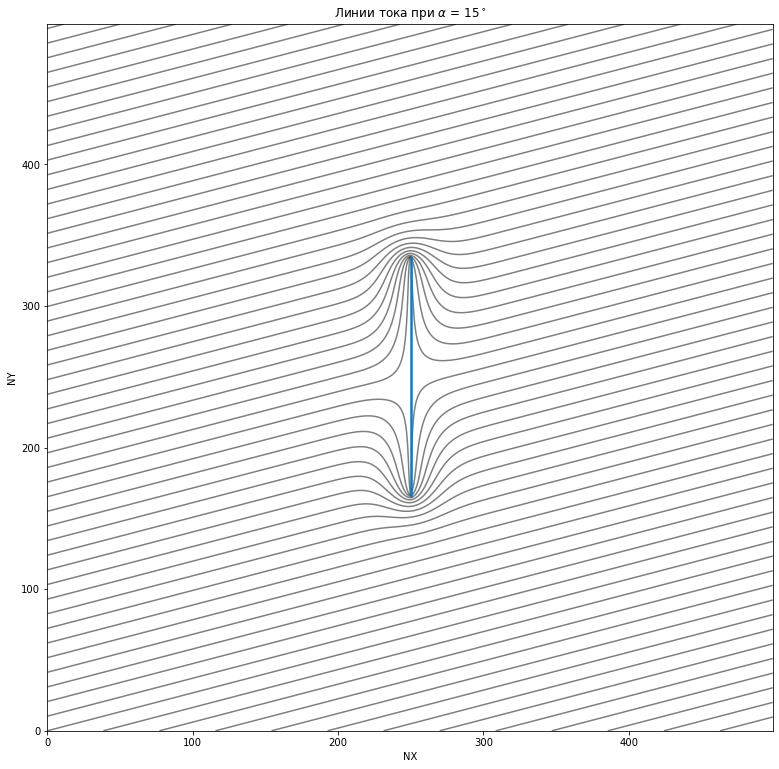

In [7]:
fig,ax = plt.subplots(figsize=(13,13))
contourf_ = ax.contour(psi_now, [ i * 0.2 for i in range(-50, 50) ], colors='k', alpha=0.5, linestyles='solid')
ax.plot([px, px], [py, py+P], lw=2.5) 

ax.set_xlabel('NX')
ax.set_ylabel('NY')
ax.set_title(r'Линии тока при $\alpha$ = {}$^\circ$'.format(alpha))
# fig.savefig('PSI.jpg', dpi=150, bbox_inches='tight')

In [93]:
k = 0

vel_x = np.zeros_like(psi_now)
vel_y = np.zeros_like(psi_now)
for i in range(1, NX-1-1):
    vel_x[i, :] = (psi_now[i-1, :] - psi_now[i+1, :]) / 2 / hx
    vel_y[:, i] = (psi_now[:, i-1] - psi_now[:, i+1]) / 2 / hy

In [96]:
vx = vel_x*vel_x
vy = vel_y*vel_y

In [98]:
cp_all = 1.0 - np.sqrt(vx+vy)

Text(0.5, 1.0, 'Линии тока при $\\alpha$ = 15$^\\circ$')

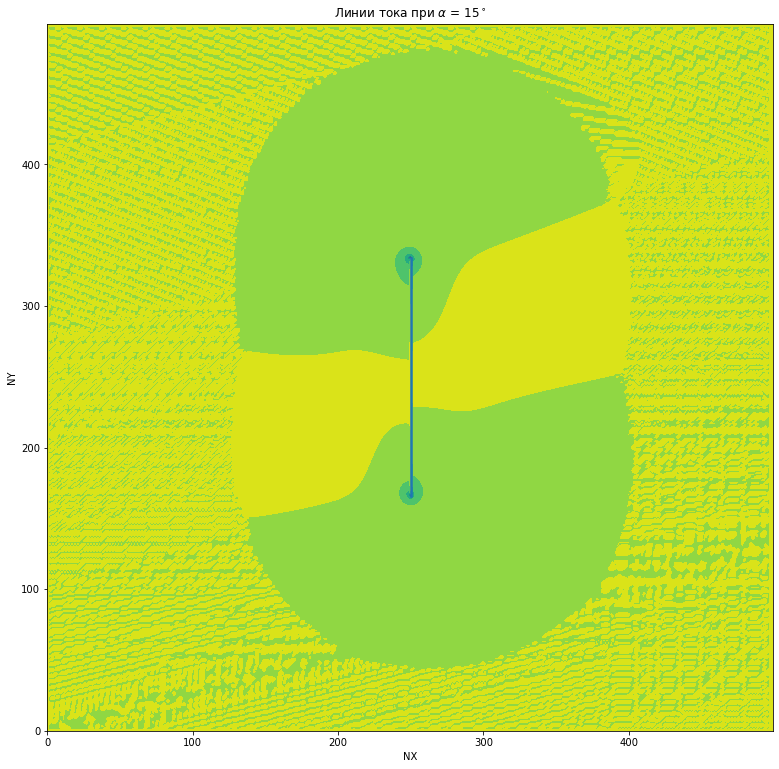

In [101]:
fig,ax = plt.subplots(figsize=(13,13))
contourf_ = ax.contourf(cp_all)
ax.plot([px, px], [py, py+P], lw=2.5) 

ax.set_xlabel('NX')
ax.set_ylabel('NY')
ax.set_title(r'Линии тока при $\alpha$ = {}$^\circ$'.format(alpha))
# fig.savefig('PSI.jpg', dpi=150, bbox_inches='tight')